In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap


In [2]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

In [3]:
import os
if os.path.isfile(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print 'CaffeNet found.'
else:
    print 'Downloading pre-trained CaffeNet model...'
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

/bin/sh: 1: ../scripts/download_model_binary.py: Permission denied


In [4]:
caffe.set_mode_cpu()

model_def = caffe_root + 'myself/fine-ResNet-50/two_classification_problem/weighted-fine-resnet-128-6/deploy-50.prototxt'
model_weights = caffe_root + 'myself/fine-ResNet-50/two_classification_problem/weighted-fine-resnet-128-6/caffe_alexnet_train_12_iter_2000.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [5]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR


mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


In [9]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(50,        # batch size
                          3,         # 3-channel (BGR) images
                          112, 112)  # image size is 227x227

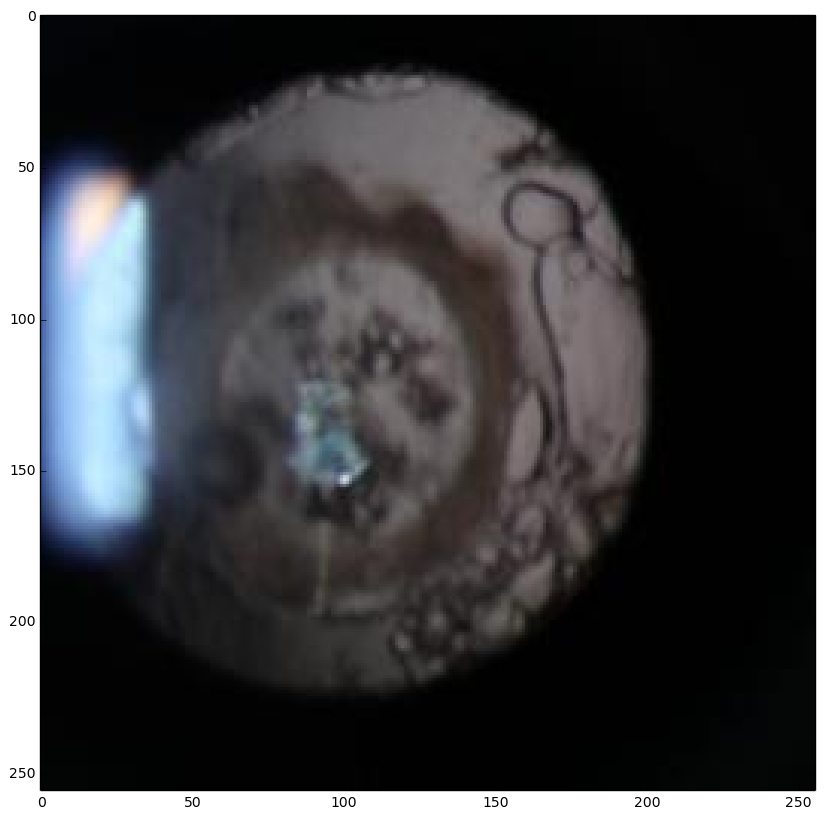

In [52]:
image = caffe.io.load_image(caffe_root + 'myself/twoclass_test_data/surgery/1/20121018-2618-35025.jpg')
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

In [53]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

### perform classification
output = net.forward()

output_prob = output['prob'][0]  # the output probability vector for the first image in the batch

print 'predicted class is:', output_prob.argmax()

predicted class is: 1


In [54]:
# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:2]  # reverse sort and take five largest items

print output_prob[top_inds]


[  9.99999881e-01   1.04993589e-07]


In [55]:
%timeit net.forward()

10 loops, best of 3: 51.8 ms per loop


In [56]:
caffe.set_device(0)  # if we have multiple GPUs, pick the first one
caffe.set_mode_gpu()
net.forward()  # run once before timing to set up memory
%timeit net.forward()

10 loops, best of 3: 51.7 ms per loop


In [57]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)



data	(50, 3, 112, 112)
conv1	(50, 64, 56, 56)
pool1	(50, 64, 28, 28)
pool1_pool1_0_split_0	(50, 64, 28, 28)
pool1_pool1_0_split_1	(50, 64, 28, 28)
res2a_branch1	(50, 256, 28, 28)
res2a_branch2a	(50, 64, 28, 28)
res2a_branch2b	(50, 64, 28, 28)
res2a_branch2c	(50, 256, 28, 28)
res2a	(50, 256, 28, 28)
res2a_res2a_relu_0_split_0	(50, 256, 28, 28)
res2a_res2a_relu_0_split_1	(50, 256, 28, 28)
res2b_branch2a	(50, 64, 28, 28)
res2b_branch2b	(50, 64, 28, 28)
res2b_branch2c	(50, 256, 28, 28)
res2b	(50, 256, 28, 28)
res2b_res2b_relu_0_split_0	(50, 256, 28, 28)
res2b_res2b_relu_0_split_1	(50, 256, 28, 28)
res2c_branch2a	(50, 64, 28, 28)
res2c_branch2b	(50, 64, 28, 28)
res2c_branch2c	(50, 256, 28, 28)
res2c	(50, 256, 28, 28)
res2c_res2c_relu_0_split_0	(50, 256, 28, 28)
res2c_res2c_relu_0_split_1	(50, 256, 28, 28)
res3a_branch1	(50, 512, 14, 14)
res3a_branch2a	(50, 128, 14, 14)
res3a_branch2b	(50, 128, 14, 14)
res3a_branch2c	(50, 512, 14, 14)
res3a	(50, 512, 14, 14)
res3a_res3a_relu_0_split_0	(50, 5

In [58]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape)


conv1	(64, 3, 7, 7)
bn_conv1	(64,)
scale_conv1	(64,)
res2a_branch1	(256, 64, 1, 1)
bn2a_branch1	(256,)
scale2a_branch1	(256,)
res2a_branch2a	(64, 64, 1, 1)
bn2a_branch2a	(64,)
scale2a_branch2a	(64,)
res2a_branch2b	(64, 64, 3, 3)
bn2a_branch2b	(64,)
scale2a_branch2b	(64,)
res2a_branch2c	(256, 64, 1, 1)
bn2a_branch2c	(256,)
scale2a_branch2c	(256,)
res2b_branch2a	(64, 256, 1, 1)
bn2b_branch2a	(64,)
scale2b_branch2a	(64,)
res2b_branch2b	(64, 64, 3, 3)
bn2b_branch2b	(64,)
scale2b_branch2b	(64,)
res2b_branch2c	(256, 64, 1, 1)
bn2b_branch2c	(256,)
scale2b_branch2c	(256,)
res2c_branch2a	(64, 256, 1, 1)
bn2c_branch2a	(64,)
scale2c_branch2a	(64,)
res2c_branch2b	(64, 64, 3, 3)
bn2c_branch2b	(64,)
scale2c_branch2b	(64,)
res2c_branch2c	(256, 64, 1, 1)
bn2c_branch2c	(256,)
scale2c_branch2c	(256,)
res3a_branch1	(512, 256, 1, 1)
bn3a_branch1	(512,)
scale3a_branch1	(512,)
res3a_branch2a	(128, 256, 1, 1)
bn3a_branch2a	(128,)
scale3a_branch2a	(128,)
res3a_branch2b	(128, 128, 3, 3)
bn3a_branch2b	(128,)
sc

In [59]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

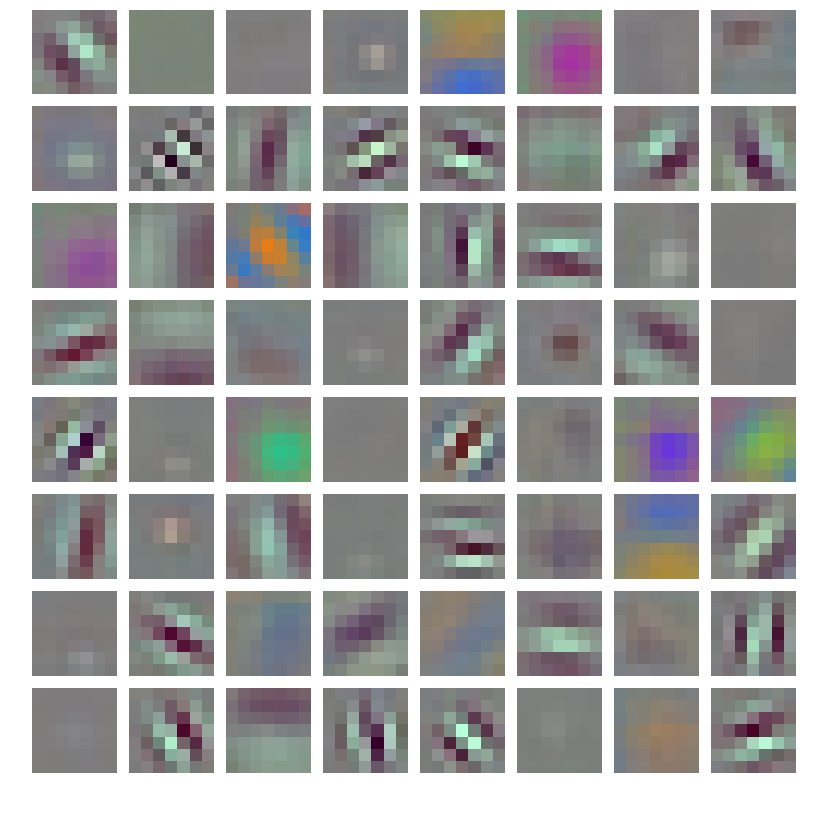

In [60]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))



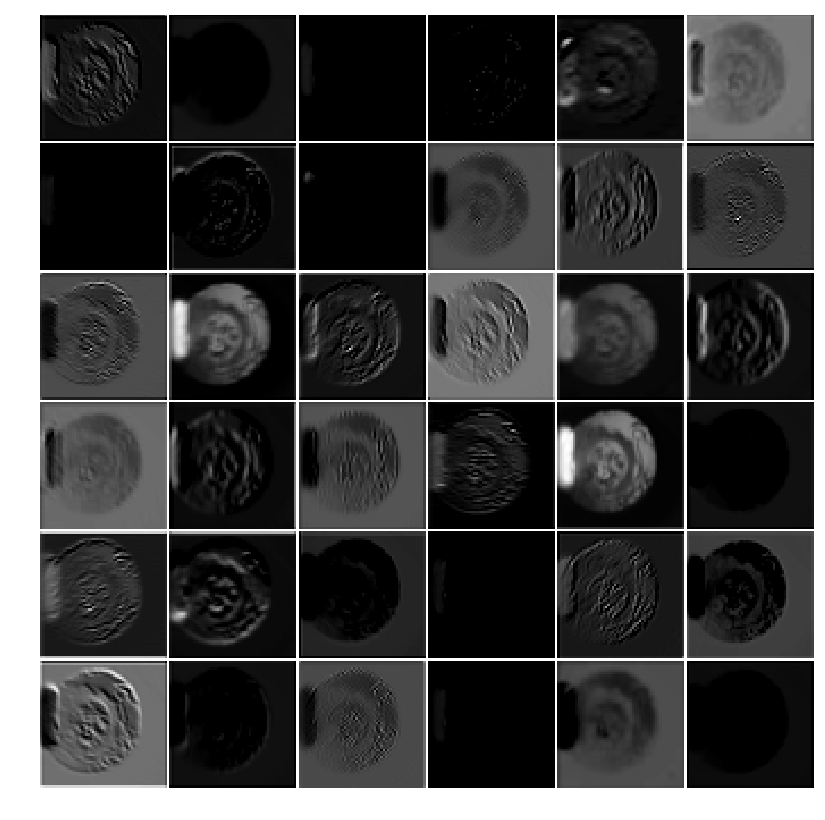

In [64]:
feat = net.blobs['conv1'].data[0,:36]
vis_square(feat)


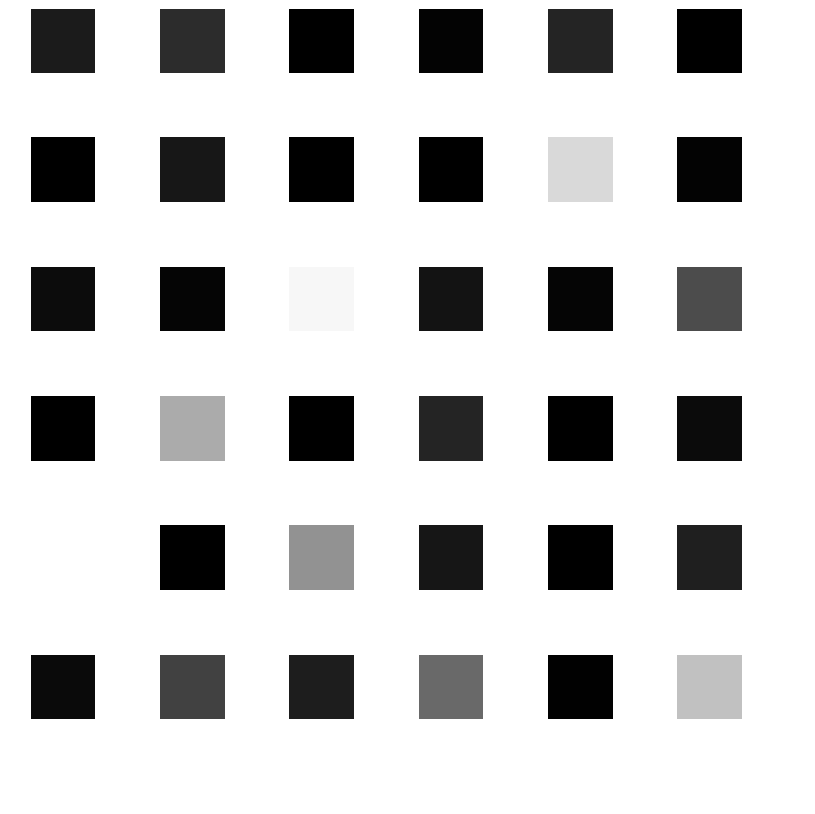

In [65]:
feat = net.blobs['pool5'].data[0,:36]
vis_square(feat)

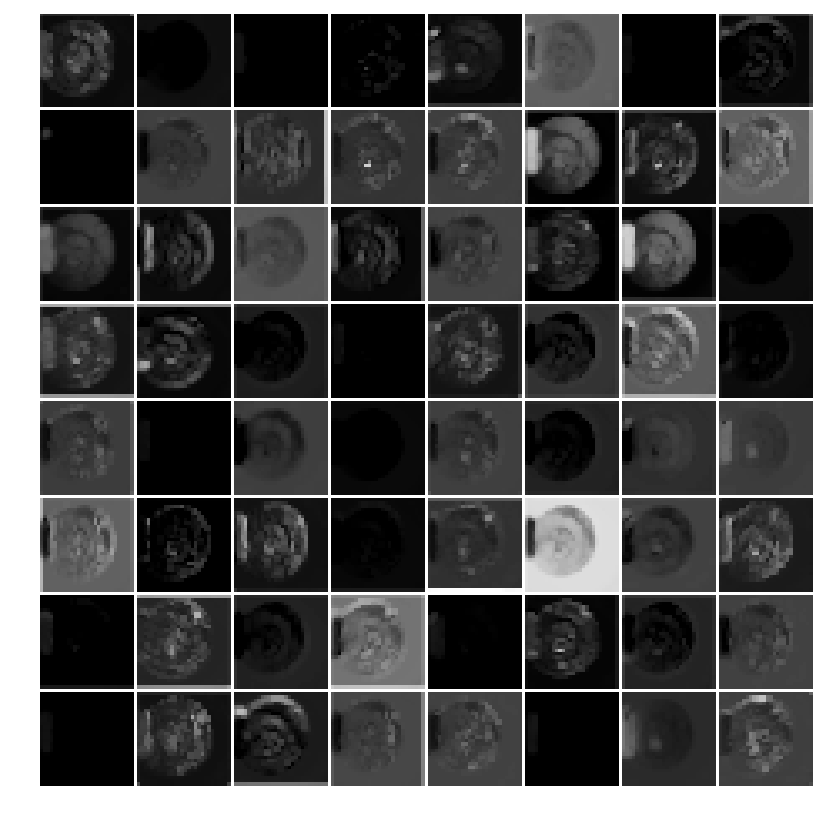

In [66]:
feat = net.blobs['pool1'].data[0]
vis_square(feat)


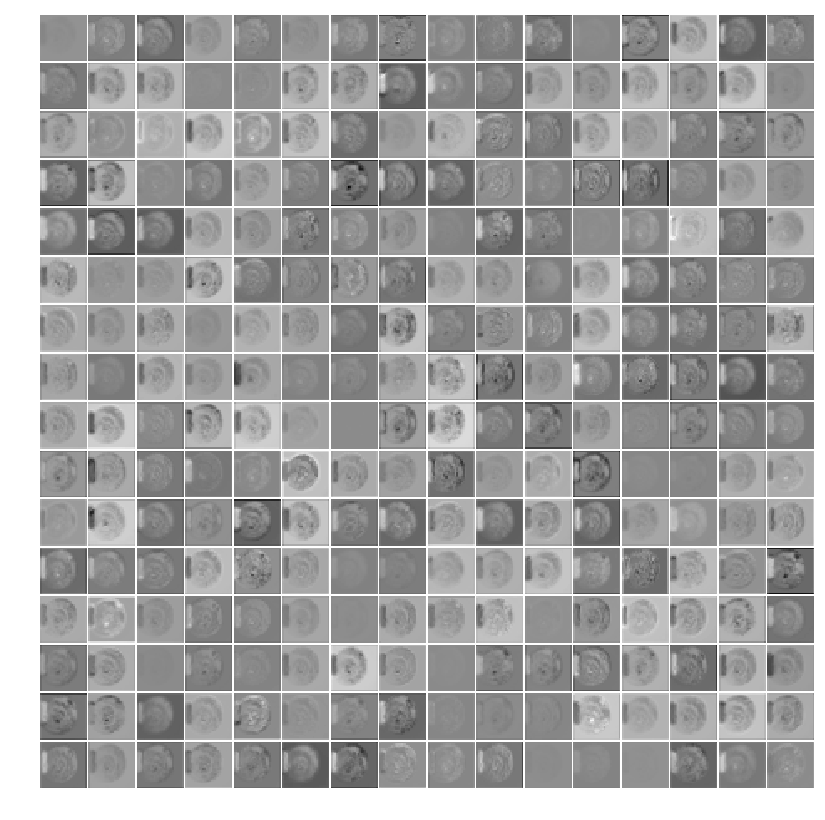

In [67]:
feat = net.blobs['res2a_branch1'].data[0]
vis_square(feat)


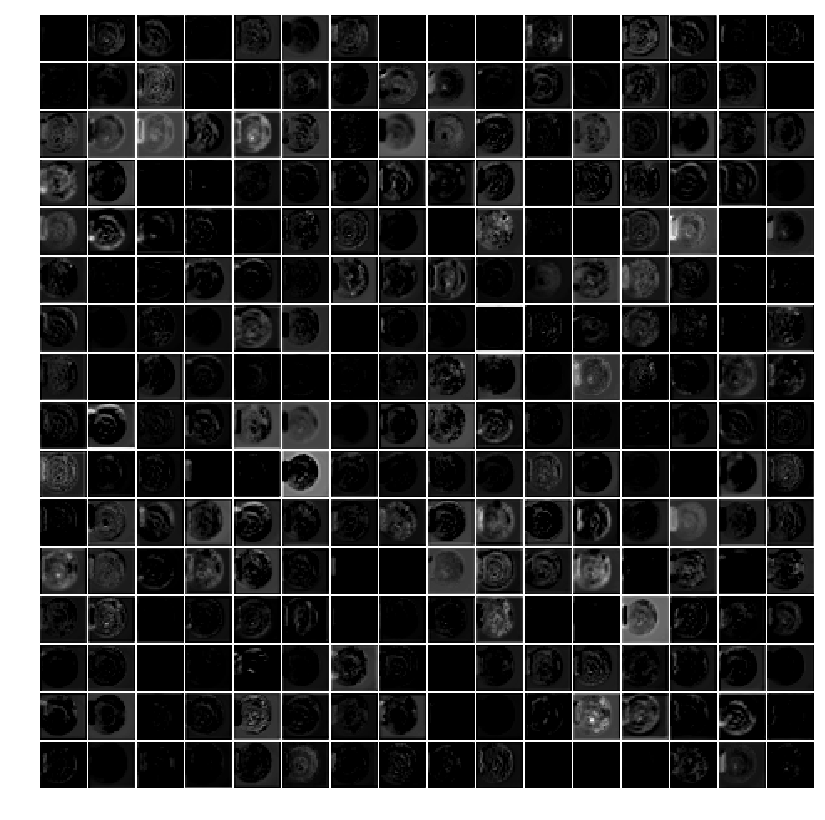

In [68]:
feat = net.blobs['res2a'].data[0]
vis_square(feat)


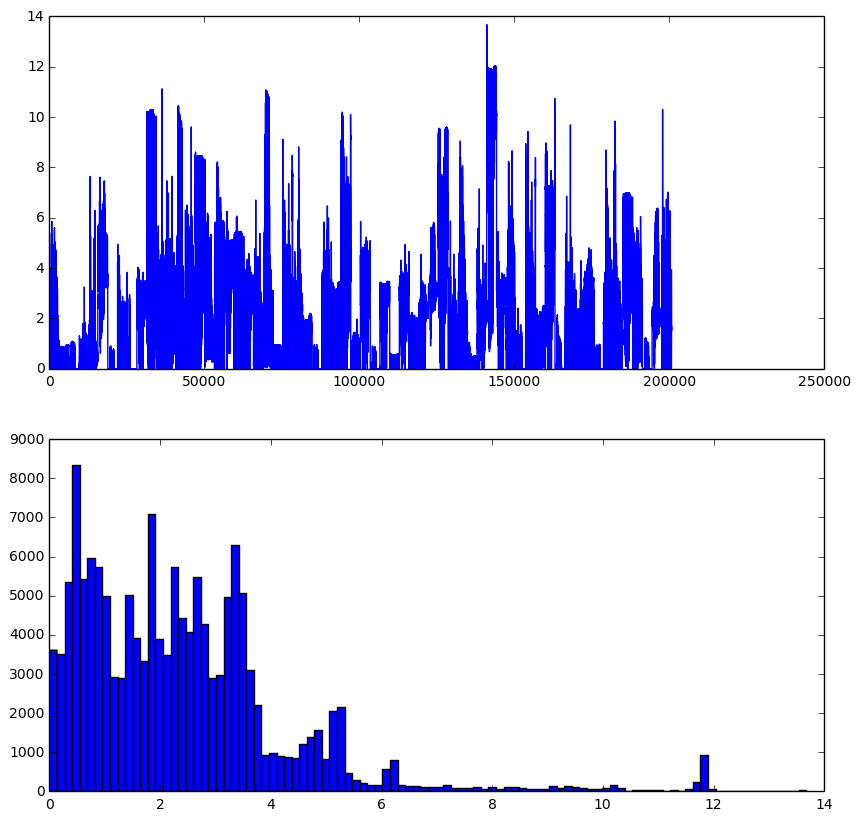

In [69]:
feat = net.blobs['conv1'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

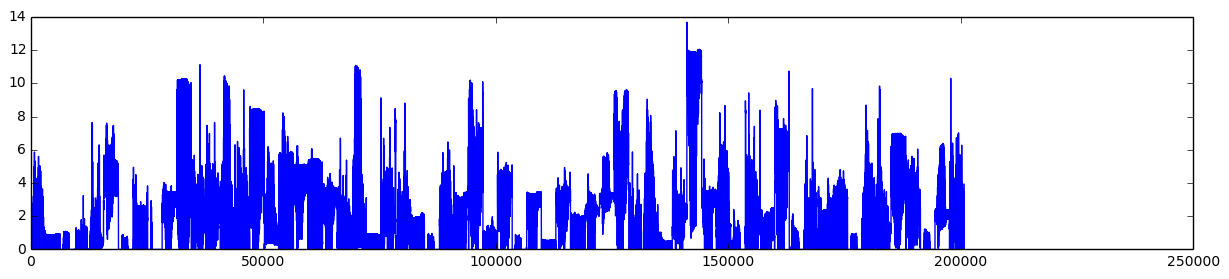

In [70]:
feat = net.blobs['conv1'].data[0]
plt.figure(figsize=(15, 3))
plt.plot(feat.flat)

TypeError: Invalid dimensions for image data

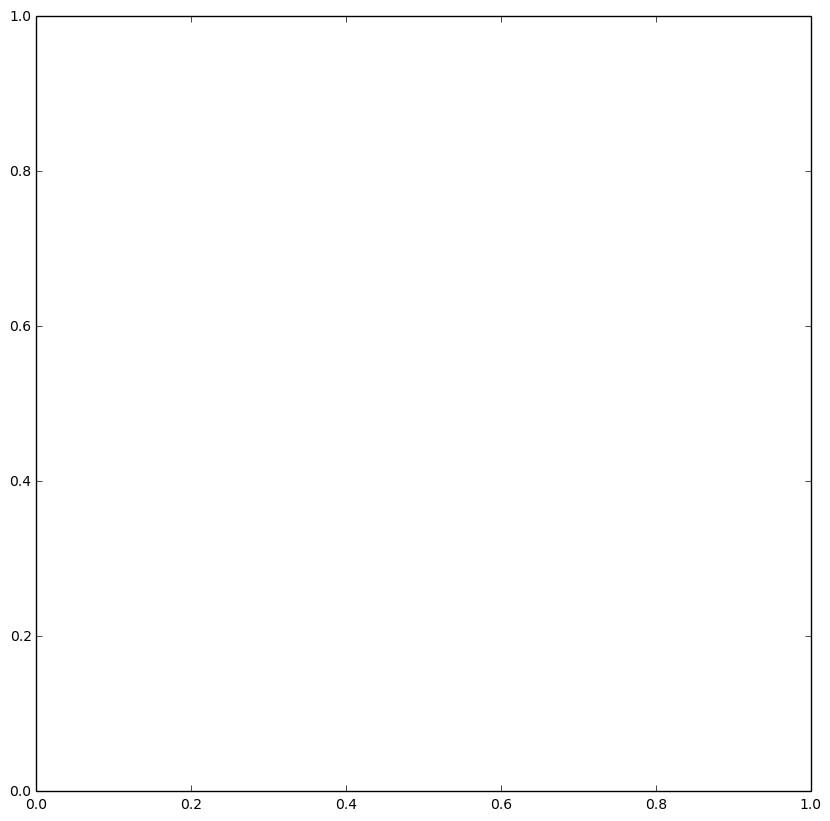

In [74]:
# the parameters are a list of [weights, biases]
filters = net.params['res2a_branch1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))
